## Prepare environment

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
!pip install decord

In [3]:
import os
import pickle
import numpy as np
import pandas as pd

In [4]:
from decord import VideoReader
from decord import cpu
from decord.bridge import set_bridge

In [5]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import seaborn as sns

In [6]:
SEED = 42
# competition settings
track = "mini_track"
num_subs = 10
train_data_len = 1000
REPETITIONS = 3

# environment settings
PROJECT_FOLDER = "/gdrive/MyDrive/Projects/algonauts/"
DATA_FOLDER = "/home/data/"

FMRI_FOLDER = f"{DATA_FOLDER}participants_data_v2021/{track}/"
VID_FOLDER  = f"{DATA_FOLDER}AlgonautsVideos268_All_30fpsmax/"

In [7]:
# !mkdir {DATA_FOLDER}
# !unzip -qq {PROJECT_FOLDER}data/participants_data.zip -d /home/data/

## Helper methods for fmri and video manipulation, metric function

In [8]:
def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    # ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    
    ROI_data_train = ROI_data["train"]
    
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

In [9]:
def load_video(fn):
    with open(fn, 'rb') as f:
        vr = VideoReader(f, ctx=cpu(0))

    vid_len = len(vr)
    frame_batch = range(0, vid_len)
    data = vr.get_batch(frame_batch)
    data = data.asnumpy()
    return data, np.round(vr.get_avg_fps())

In [10]:
def vectorized_correlation(x,y):
    dim = 0
    x = np.array(x)
    y = np.array(y)

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel().mean()

## Prepare data

In [11]:
if track == 'full_track':
    ROIs = ['WB']
else:
    ROIs = ['LOC','FFA','STS','EBA','PPA','V1','V2','V3','V4']

subs=[]
for s in range(num_subs):
    subs.append('sub'+str(s+1).zfill(2))

In [12]:
fmri_data = {}

In [13]:
for sub in subs:
    fmri_ROI_mapping = {}
    fmri_voxel_total = 0

    # get selected voxel count for each ROI and create data mapping
    for ROI in ROIs:
        ROI_data = get_fmri(FMRI_FOLDER + sub, ROI)
        ROI_voxel_count = ROI_data.shape[2]
        fmri_ROI_mapping[ROI] = [fmri_voxel_total, fmri_voxel_total + ROI_voxel_count, ROI_voxel_count]
        fmri_voxel_total += ROI_voxel_count

    sub_fmri_data = np.empty((train_data_len, 3, fmri_voxel_total))

    for ROI in ROIs:
        ROI_mapping = fmri_ROI_mapping[ROI]
        sub_fmri_data[:, :, ROI_mapping[0]:ROI_mapping[1]] = get_fmri(FMRI_FOLDER + sub, ROI)

    fmri_data[sub] = {"mapping": fmri_ROI_mapping,
                      "data": sub_fmri_data}

In [14]:
print(fmri_data["sub01"]["mapping"])

{'LOC': [0, 1843, 1843], 'FFA': [1843, 1911, 68], 'STS': [1911, 2252, 341], 'EBA': [2252, 2603, 351], 'PPA': [2603, 3028, 425], 'V1': [3028, 3260, 232], 'V2': [3260, 3491, 231], 'V3': [3491, 3752, 261], 'V4': [3752, 3859, 107]}


## Visualize FMRI data

In [15]:
ROI = "V1"
sub = "sub01"

sub_fmri_data = fmri_data[sub]
fmri = sub_fmri_data["data"]
mapping = sub_fmri_data["mapping"]

Text(0.5, 0.98, 'sub01 - ROI V1')

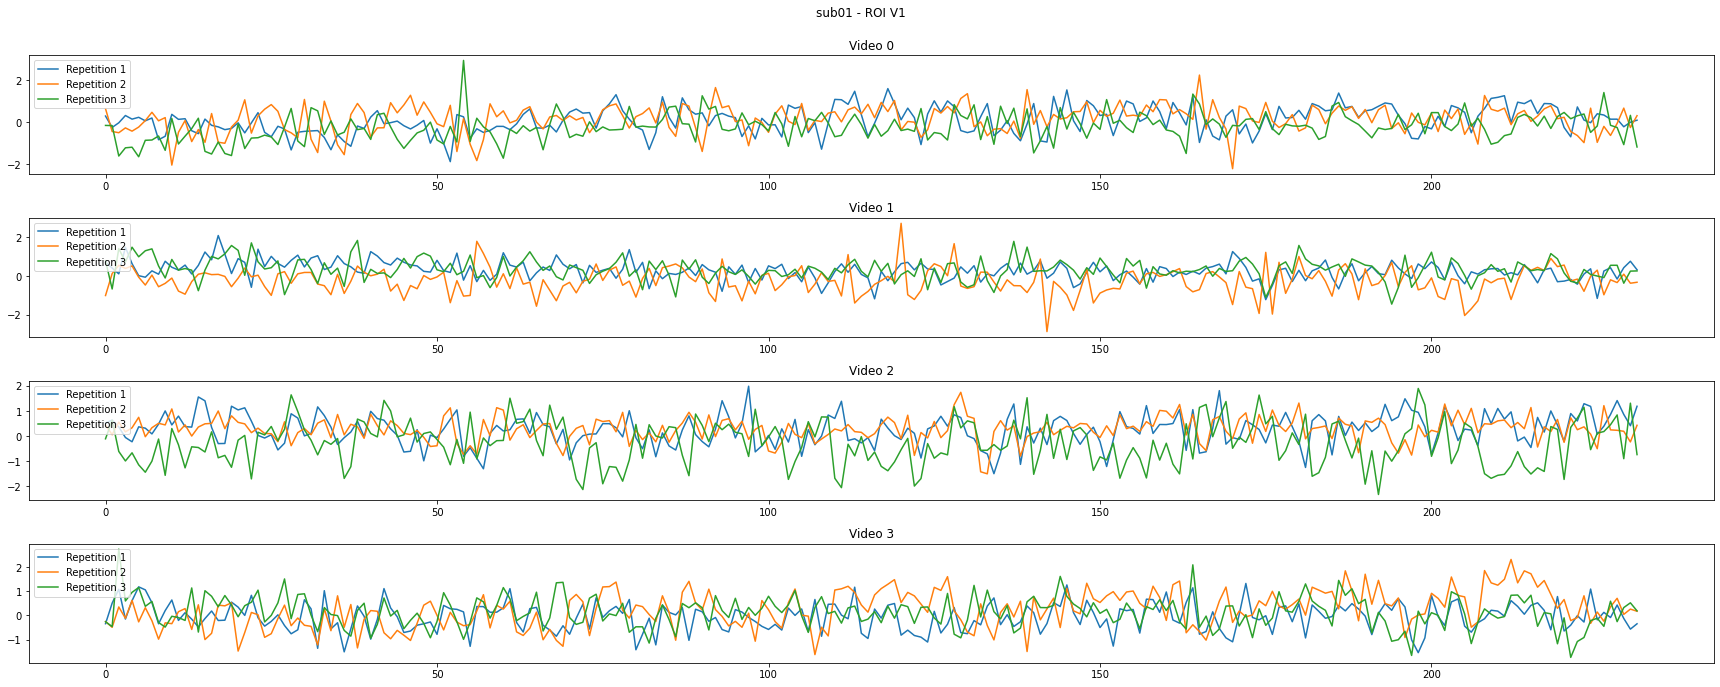

In [16]:
fig, axes = plt.subplots(4, 1, figsize=(24,10))
for i in range(4):
    vid_roi_fmri_response = fmri[i, :, mapping[ROI][0]:mapping[ROI][1]]
    axes[i].plot(vid_roi_fmri_response.T)
    axes[i].legend(["Repetition 1", "Repetition 2", "Repetition 3"], loc="upper left")
    axes[i].title.set_text(f"Video {i}")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(f"{sub} - ROI {ROI}")

Text(0.5, 0.98, 'sub01 - Voxel activity distribution')

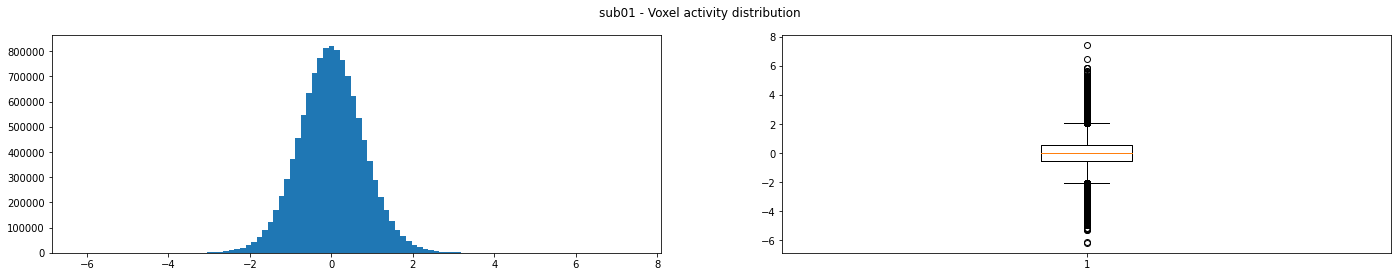

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(24,4))
axes[0].hist(np.ravel(fmri), bins=100)
axes[1].boxplot(np.ravel(fmri))
fig.suptitle(f"{sub} - Voxel activity distribution")

Text(0.5, 0.98, 'sub01 - Voxel activity distribution in each ROI')

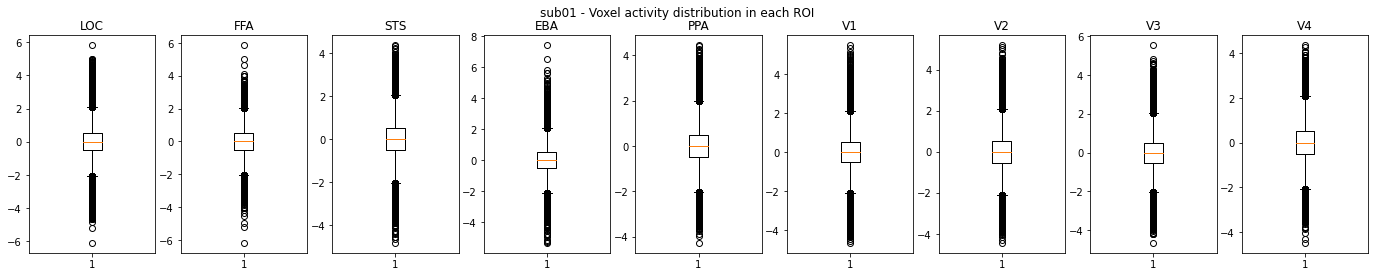

In [18]:
fig, axes = plt.subplots(1, len(ROIs), figsize=(24,4))
for i, ROI in enumerate(ROIs):
    roi_mapping = mapping[ROI]
    axes[i].boxplot(np.ravel(fmri[:, :, roi_mapping[0]:roi_mapping[1]]))
    axes[i].title.set_text(ROI)

fig.suptitle(f"{sub} - Voxel activity distribution in each ROI")

## Repetition correlation

In [19]:
repetition_correlation = np.zeros((1000, 3))

for i in range(1000):
    res = np.zeros((3, 3))
    for j in range(3):
        for k in range(3):
            res[j, k] = vectorized_correlation(fmri[i, j, :], fmri[i, k, :])

    repetition_correlation[i, :] = res[np.triu_indices(3, k=1)]

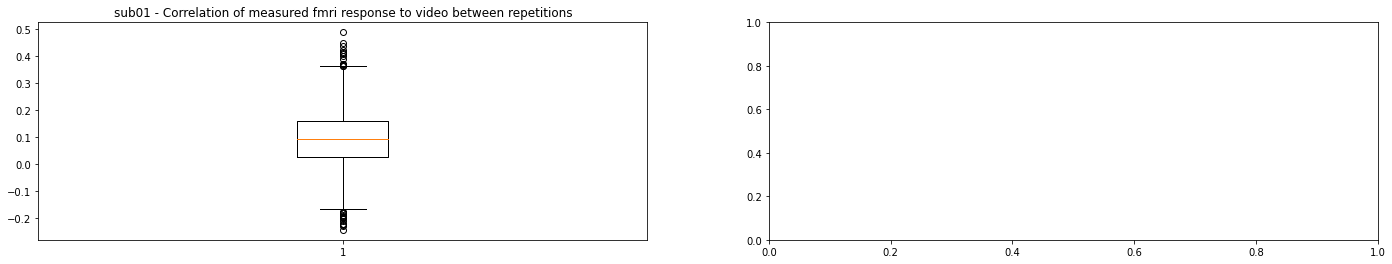

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(24,4))
axes[0].boxplot(np.ravel(repetition_correlation))
axes[0].title.set_text(f"{sub} - Correlation of measured fmri response to video between repetitions")

In [21]:
res = np.zeros((3, 3))
for j in range(3):
    for k in range(3):
        res[j, k] = vectorized_correlation(fmri[:, j, :], fmri[:, k, :])

print(f"{sub} - Correlation between repetition across all videos")
print(res[np.triu_indices(3, k=1)])

sub01 - Correlation between repetition across all videos
[0.09456581 0.09983221 0.08670211]


Text(0.5, 0.98, 'sub01 - Correlation of measured fmri response to video between repetitions')

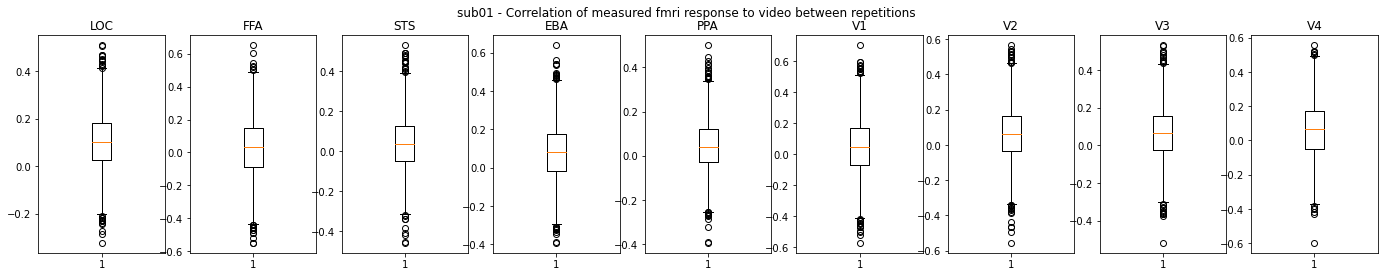

In [22]:
fig, axes = plt.subplots(1, len(ROIs), figsize=(24,4))

for index, ROI in enumerate(ROIs):
    repetition_correlation = np.zeros((1000, 3))
    roi_mapping = mapping[ROI]
    roi_fmri_data = fmri[:, :, roi_mapping[0]:roi_mapping[1]]
    for i in range(1000):
        res = np.zeros((3, 3))
        for j in range(3):
            for k in range(3):
                res[j, k] = vectorized_correlation(roi_fmri_data[i, j, :], roi_fmri_data[i, k, :])

        repetition_correlation[i, :] = res[np.triu_indices(3, k=1)]

    axes[index].boxplot(np.ravel(repetition_correlation))
    axes[index].title.set_text(ROI)

fig.suptitle(f"{sub} - Correlation of measured fmri response to video between repetitions")

In [23]:
print(f"{sub} - Correlation between repetitions across all videos")
for i, ROI in enumerate(ROIs):
    roi_fmri_data = fmri[:, :, mapping[ROI][0]:mapping[ROI][1]]
    res = np.zeros((3, 3))
    for j in range(3):
        for k in range(3):
            res[j, k] = vectorized_correlation(roi_fmri_data[:, j, :], roi_fmri_data[:, k, :])

    print(ROI, res[np.triu_indices(3, k=1)])

sub01 - Correlation between repetitions across all videos
LOC [0.11123097 0.12115264 0.10385378]
FFA [0.08082505 0.07565007 0.07098057]
STS [0.06015719 0.06281515 0.04035551]
EBA [0.10916699 0.11967906 0.10540538]
PPA [0.08207304 0.07694059 0.07258339]
V1 [0.06529484 0.05549689 0.0586172 ]
V2 [0.07463427 0.08193263 0.07252149]
V3 [0.07606329 0.08037936 0.07051789]
V4 [0.07926147 0.07398294 0.07468206]


## Voxel correlation

In [24]:
mean_over_rep = fmri.mean(1)

In [25]:
corr_matrix = np.corrcoef(mean_over_rep.T)
ind = np.triu_indices(len(corr_matrix), k=1)
corr_triu = corr_matrix[ind]
I_sort = np.argsort(corr_triu)

Most correlated voxels: 865 879
Correlation: 0.9768267860844473


Text(0.5, 0.98, 'Mean RSE: 0.11656080189147242')

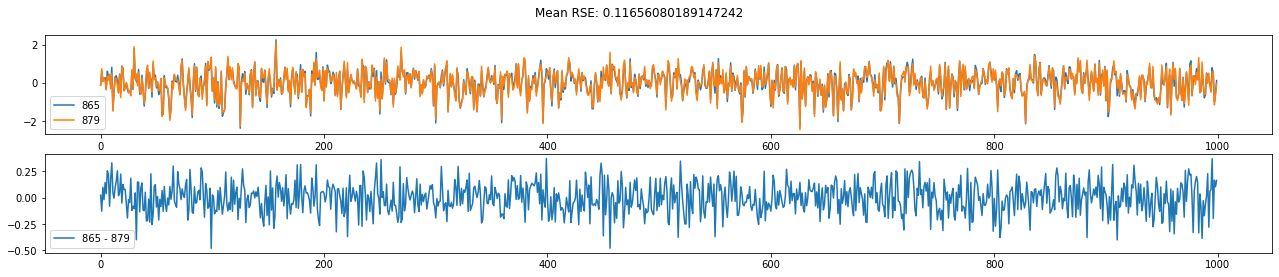

In [26]:
I = -1
print("Most correlated voxels:", ind[0][I_sort[I]], ind[1][I_sort[I]])
print(f"Correlation: {corr_triu[I_sort[I]]}")

fig, axes = plt.subplots(2,1, figsize=(22,4))
a = mean_over_rep[:, ind[0][I_sort[I]]]
b = mean_over_rep[:, ind[1][I_sort[I]]]

a_label = str(ind[0][I_sort[I]])
b_label = str(ind[1][I_sort[I]])

axes[0].plot(a, label=a_label)
axes[0].plot(b, label=b_label)
axes[0].legend()
axes[1].plot(a-b, label=f"{a_label} - {b_label}")
axes[1].legend()
fig.suptitle(f"Mean RSE: {np.mean(np.sqrt((a-b)**2))}")

{'boxes': [<matplotlib.lines.Line2D at 0x7f53086b2390>],
 'caps': [<matplotlib.lines.Line2D at 0x7f530871e2d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f53087224d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f530a721e50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f53085bcbd0>,
  <matplotlib.lines.Line2D at 0x7f530868ba90>]}

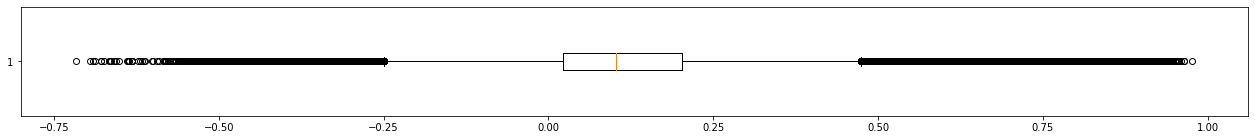

In [27]:
plt.figure(figsize=(22,2))
plt.boxplot(corr_triu, vert=False)

In [28]:
plt.figure(figsize=(22,22))
plt.imshow(corr_matrix)
plt.title("Voxel correlation matrix")

Output hidden; open in https://colab.research.google.com to view.

## Video response correlation

In [29]:
corr_matrix = np.corrcoef(mean_over_rep)
ind = np.triu_indices(len(corr_matrix), k=1)
corr_triu = corr_matrix[ind]
I_sort = np.argsort(corr_triu)

Most correlated videos: 359 660
Correlation: 0.6550905656730638


Text(0.5, 0.98, 'Mean RSE: 0.4625712178065281')

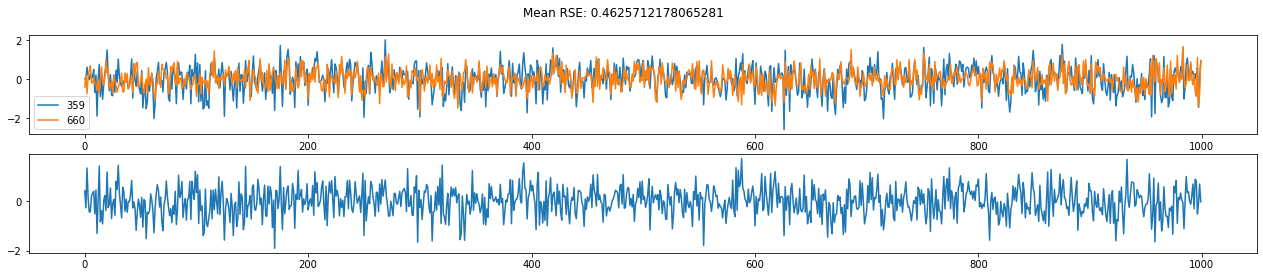

In [30]:
I = -1
print("Most correlated videos:", ind[0][I_sort[I]], ind[1][I_sort[I]])
print(f"Correlation: {corr_triu[I_sort[I]]}")

fig, axes = plt.subplots(2,1, figsize=(22,4))
a = mean_over_rep[:, ind[0][I_sort[I]]]
b = mean_over_rep[:, ind[1][I_sort[I]]]

axes[0].plot(a, label=str(ind[0][I_sort[I]]))
axes[0].plot(b, label=str(ind[1][I_sort[I]]))
axes[0].legend()
axes[1].plot(a-b)
fig.suptitle(f"Mean RSE: {np.mean(np.sqrt((a-b)**2))}")

{'boxes': [<matplotlib.lines.Line2D at 0x7f530840ddd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f5307e1f590>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5307e255d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f5307e25090>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f5307e98ad0>,
  <matplotlib.lines.Line2D at 0x7f5307e1f050>]}

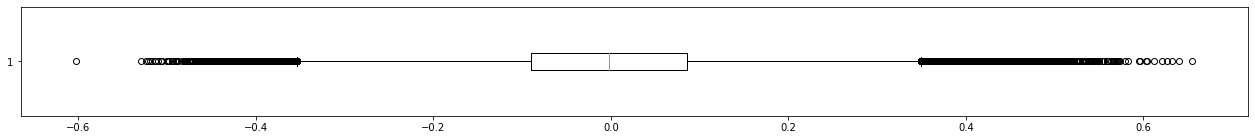

In [31]:
plt.figure(figsize=(22,2))
plt.boxplot(corr_triu, vert=False)

In [32]:
from sklearn.linear_model import LinearRegression

sub = "sub01"
sub_fmri_data = fmri_data[sub]
fmri = sub_fmri_data["data"]
mapping = sub_fmri_data["mapping"]

def flatten(data, reduction="mean"):
    if reduction is None:
        N, R, V = np.shape(data)
        return data.reshape(N * R, V)
    elif reduction == "mean":
        return data.mean(1)
    
    raise Exception("Unknown reduction")

print("RMSE of ROI prediction using other ROIs data")

train_fmri_data  = fmri[0:900, :, :]
valid_fmri_data  = fmri[900:1000, :, :]

for ROI in ROIs:
    roi_mapping = mapping[ROI]
    # get data for training
    target_fmri_data = flatten(train_fmri_data[:, :, roi_mapping[0]:roi_mapping[1]])
    source_fmri_data = np.concatenate((train_fmri_data[:, :, :roi_mapping[0]], train_fmri_data[:, :, roi_mapping[1]:]), axis=2)
    source_fmri_data = flatten(source_fmri_data)
    # train regressor
    reg = LinearRegression().fit(source_fmri_data, target_fmri_data)
    pred = reg.predict(source_fmri_data)
    train_RMSE = np.sqrt(np.mean((pred - target_fmri_data) ** 2))
    # get data for validation
    target_fmri_data = flatten(valid_fmri_data[:, :, roi_mapping[0]:roi_mapping[1]])
    source_fmri_data = np.concatenate((valid_fmri_data[:, :, :roi_mapping[0]], valid_fmri_data[:, :, roi_mapping[1]:]), axis=2)
    source_fmri_data = flatten(source_fmri_data)
    # validate and print result
    pred = reg.predict(source_fmri_data)
    valid_RMSE = np.sqrt(np.mean((pred - target_fmri_data) ** 2))
    print(f"{ROI:<3} - train RMSE: {train_RMSE:.4f}, valid_RMSE: {valid_RMSE:.4f}")

RMSE of ROI prediction using other ROIs data
LOC - train RMSE: 0.0000, valid_RMSE: 0.4206
FFA - train RMSE: 0.0000, valid_RMSE: 0.3627
STS - train RMSE: 0.0000, valid_RMSE: 0.3871
EBA - train RMSE: 0.0000, valid_RMSE: 0.3193
PPA - train RMSE: 0.0000, valid_RMSE: 0.4175
V1  - train RMSE: 0.0000, valid_RMSE: 0.3103
V2  - train RMSE: 0.0000, valid_RMSE: 0.3097
V3  - train RMSE: 0.0000, valid_RMSE: 0.3432
V4  - train RMSE: 0.0000, valid_RMSE: 0.3429


In [33]:
roi_pred_rmse = pd.DataFrame(index=ROIs, columns=ROIs)
for ROI_1 in ROIs:
    roi_mapping = mapping[ROI_1]
    train_roi_fmri_data = flatten(train_fmri_data[:, :, roi_mapping[0]:roi_mapping[1]])
    valid_roi_fmri_data = flatten(valid_fmri_data[:, :, roi_mapping[0]:roi_mapping[1]])
    
    for ROI_2 in ROIs:
        target_roi_mapping = mapping[ROI_2]
        target_roi_data = flatten(train_fmri_data[:, :, target_roi_mapping[0]:target_roi_mapping[1]])
        reg = LinearRegression().fit(train_roi_fmri_data, target_roi_data)

        target_roi_data = flatten(valid_fmri_data[:, :, target_roi_mapping[0]:target_roi_mapping[1]])
        pred = reg.predict(valid_roi_fmri_data)
        RMSE = np.sqrt(np.mean((pred - target_roi_data) ** 2))
        roi_pred_rmse[ROI_1][ROI_2] = RMSE

Text(0.5, 1.0, 'Voxel activity prediction RMSE')

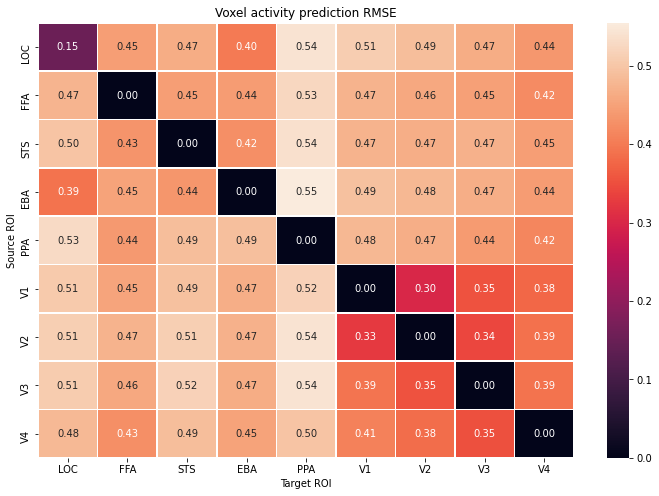

In [34]:
roi_pred_rmse = roi_pred_rmse.astype('float32')
plt.figure(figsize=(12,8))
ax = sns.heatmap(roi_pred_rmse, linewidths=.5, annot=True, fmt=".2f")
ax.set_xlabel("Target ROI")
ax.set_ylabel("Source ROI")
ax.set_title("Voxel activity prediction RMSE")

## Video

In [35]:
vid_files = sorted(os.listdir(VID_FOLDER))

In [36]:
print("Number of videos:", len(vid_files))

Number of videos: 1102


In [37]:
vid_meta = np.zeros((len(vid_files), 4))
for i, fn in enumerate(vid_files):
    data, fps = load_video(VID_FOLDER + fn)
    t, x, y, c = np.shape(data)
    vid_meta[i, :] = [x, y, t, fps]

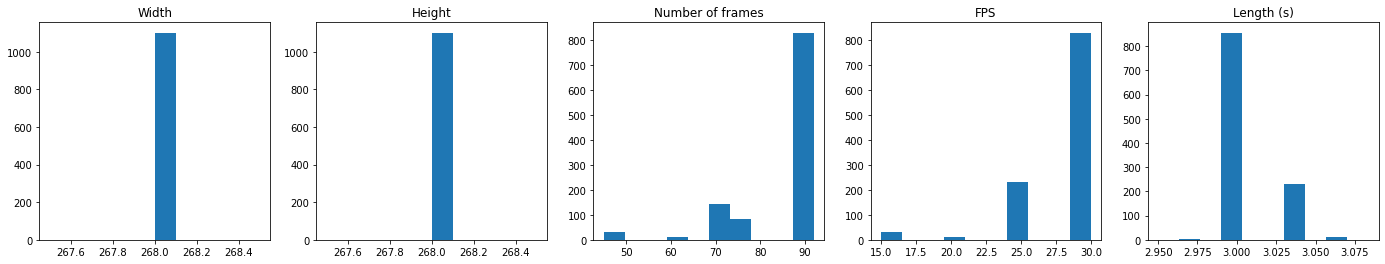

In [38]:
fig, axes = plt.subplots(1, 5, figsize=(24,4))

axes[0].hist(vid_meta[:, 0])
axes[0].title.set_text("Width")

axes[1].hist(vid_meta[:, 1])
axes[1].title.set_text("Height")

axes[2].hist(vid_meta[:, 2])
axes[2].title.set_text("Number of frames")

axes[3].hist(vid_meta[:, 3])
axes[3].title.set_text("FPS")

axes[4].hist(vid_meta[:, 2] / vid_meta[:, 3])
axes[4].title.set_text("Length (s)")

In [39]:
vid_i = ind[0][I_sort[I]]
fn = vid_files[vid_i]
vid, fps = load_video(VID_FOLDER + fn)

def init_vid():
    im.set_data(vid[0,:,:])

def animate_vid(i):
    im.set_data(vid[i,:,:])
    return im

fig = plt.figure()
im = plt.imshow(vid[0,:,:])

plt.close() # this is required to not display the generated image
anim = animation.FuncAnimation(fig, animate_vid, init_func=init_vid, frames=vid.shape[0], interval=50)
HTML(anim.to_html5_video())

In [40]:
vid_i = ind[1][I_sort[I]]
fn = vid_files[vid_i]
vid, fps = load_video(VID_FOLDER + fn)

def init_vid():
    im.set_data(vid[0,:,:])

def animate_vid(i):
    im.set_data(vid[i,:,:])
    return im

fig = plt.figure()
im = plt.imshow(vid[0,:,:])

plt.close() # this is required to not display the generated image
anim = animation.FuncAnimation(fig, animate_vid, init_func=init_vid, frames=vid.shape[0], interval=50)
HTML(anim.to_html5_video())